# Predicting Genders from Images Using Random Forest Classifier

Author: Haoliang Jiang

In [ ]:
from sklearn import metrics
import os
import condacolab
from google.colab import files
import cv2
import os
import random
import numpy as np
import tarfile
from sklearn.model_selection import train_test_split
import cudf
from cuml.ensemble import RandomForestClassifier as cuRFC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from cuml.ensemble import RandomForestClassifier as cuRFC
import matplotlib.pyplot as plt
import pickle

For this project, the image dataset is enormous, and it is not practical to train the model using local machines and a cpu. As a result, I will use Google Colab Pro and get connected to a GPU for this task.  I aim to use cuML module to build a random forest model as the baseline model for the final project of IDS 705. This notebook goes thru installing your required environments, data cleaning, model training, hyperparameter tuning, and metrics evaluation. It turns out that a random forest model is not a good classifier when being used on solving computer vision problems. The overfitting issue was not resolved even after a lot of hyperparameter tuning was implemented.

In [1]:
!nvidia-smi

Tue Apr 12 13:45:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 300 (delta 72), reused 43 (delta 21), pack-reused 171
Receiving objects: 100% (300/300), 86.52 KiB | 4.12 MiB/s, done.
Resolving deltas: 100% (134/134), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla P100-PCIE-16GB!
***********************************************************************



In [ ]:
!bash rapidsai-csp-utils/colab/update_gcc.sh
os._exit(00)

In [1]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:24
🔁 Restarting kernel...


In [1]:
# you can now run the rest of the cells as normal
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [3]:
uploaded = files.upload()

Saving crop_part1.tar.gz to crop_part1.tar.gz


In [14]:
! pip install opencv-python

     |████████████████████████████████| 60.5 MB 55.0 MB/s 


In [16]:
file = tarfile.open('crop_part1.tar.gz')
# extracting file
file.extractall('./crop_part1')
file.close()

# Read In Data

In [17]:
# set a seed
random.seed(328)

# define dir
data_dir = "./crop_part1/crop_part1"

# random sampling
n = 1000
fnames_subset = random.sample(os.listdir(data_dir), n)

In [18]:
y = [] # 0 (male) or 1 (female)
for fname in fnames_subset:
    temp = fname.split("_")
    y.append(temp[1])
    pass

y = np.array(y)

In [19]:
# X: flattened version
# X_origin_dict: original version; key: index, value: 3-D np array
X_rgb = list()
X_origin_dict = dict()
for i, fname in enumerate(fnames_subset):
    # construct dir
    dir = data_dir + "/" + fname
    
    # read the data
    dat = cv2.imread(dir)
    
    # convert to rgb
    dat = cv2.cvtColor(dat, cv2.COLOR_BGR2RGB)
    
    # store the original data
    X_origin_dict[i] = dat
    
    # store the data
    X_rgb.append(dat)

# convert to np array
X_rgb = np.array(X_rgb)

In [20]:
#y = np.delete(y, 7884)
#X_rgb = np.delete(X_rgb, 7884)

# Train-Test Split and Data Cleaning

In [22]:
#Train Test Split
X_rgb_train, X_rgb_test, y_train, y_test = train_test_split(
    X_rgb, y, test_size=0.1, random_state=329
)

X_rgb_train, X_rgb_val, y_train, y_val = train_test_split(
    X_rgb_train, y_train, test_size=(0.1/0.9), random_state=525
)

In [23]:
#Flatten X
X_rgb_flattened_train = np.array([x.flatten() for x in X_rgb_train])
X_rgb_flattened_val = np.array([x.flatten() for x in X_rgb_val])
X_rgb_flattened_test = np.array([x.flatten() for x in X_rgb_test])

In [24]:
#Feature Scaling
scaler = StandardScaler()
scaler.fit(X_rgb_flattened_train)

X_rgb_flattened_train_scaled = X_rgb_flattened_train.copy() 
X_rgb_flattened_train_scaled = scaler.transform(X_rgb_flattened_train).astype(np.float32)
X_rgb_flattened_val_scaled = scaler.transform(X_rgb_flattened_val).astype(np.float32)
X_rgb_flattened_test_scaled = scaler.transform(X_rgb_flattened_test).astype(np.float32)

In [26]:
X_train = cudf.DataFrame(X_rgb_flattened_train_scaled)

In [27]:
X_val = cudf.DataFrame(X_rgb_flattened_val_scaled)

In [28]:
X_test = cudf.DataFrame(X_rgb_flattened_test_scaled)

In [29]:
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_val = y_val.astype(np.int32)

# Modelling and Parameter Tuning

In [36]:
#Create a random forest model with all default parameters
cuml_model = cuRFC()
cuml_model.fit(X_rgb_flattened_train_scaled,y_train)

RandomForestClassifier()

In [35]:
#The accuracy score is awful, which means that hyperparameter tuning is required
pred = cuml_model.predict(X_rgb_flattened_val_scaled)
cuml_model.score(X_val, y_val)

0.6200000047683716

## Randomized Search Cross Validation
First use randomized search to narrow down the range of the hyperparameters to be tuned. Here, I use cuML's random forest for modelling, which involves more hyperparameters than the sklearn version. n_bins refers to "Maximum number of bins used by the split algorithm per feature. For large problems, particularly those with highly-skewed input data, increasing the number of bins may improve accuracy." n_streams refers to "Number of parallel streams used for forest building." cuML's random forest uses gpu and parallel computing to speed up the training processes.

In [49]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(-1)
min_samples_split = [2,4,8,16,32]
min_samples_leaf = [1,2,4,8,16]
bootstrap = [True]
#split_criterion = ['gini','entropy']
max_samples = [0.25, 0.5, 0.75, 1]
n_bins = [128, 256, 384, 512]
n_streams = [4,6,8,10]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap':bootstrap,
               #'split_criterion':split_criterion,
               'max_samples':max_samples,
               'n_bins':n_bins,
               'n_streams':n_streams}

Now the randomized search cross validation method will figure out the best set of hyperparaameters to be picked. This is done to narrow down the range of hyperparameters that we should look into. And then I will use GridSearchCV to find the best combination of hyperparameters. Don't worry about the error message in the output. It just shows up because some combo of parameters cannot won't fit the model.

In [ ]:
cuml_model = cuRFC()
cuml_model_random = RandomizedSearchCV(estimator = cuml_model, 
                                       param_distributions = random_grid,
                                       n_iter = 100,
                                       cv = 3,
                                       verbose = 2,
                                       random_state = 188)
cuml_model_random.fit(X_rgb_flattened_train_scaled,y_train)
cuml_model_random.best_params_

In [51]:
cuml_model_random.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'max_samples': 1,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_bins': 512,
 'n_estimators': 800,
 'n_streams': 10}

In [42]:
cumlll = cuRFC(bootstrap= True,
 max_depth= 50,
 max_features = 'auto',
 max_samples= 1,
 min_samples_leaf= 4,
 min_samples_split= 2,
 n_bins= 512,
 n_estimators= 800,
 n_streams = 10)
cumlll.fit(X_rgb_flattened_train_scaled,y_train)

RandomForestClassifier()

In [43]:
print(cumlll.score(X_val, y_val))

0.6200000047683716

In [44]:
print(cumlll.score(X_train, y_train))
print(cumlll.score(X_test, y_test))

1.0
0.7099999785423279


As we can see from the above accuracy scores, the model is definitely overfitting. The training accuracy reaches 100%, while the validationa and testing accuracies are in the 60s and 70s. As a result, a grid search cross validatio will be performed to see if the model performance can be improved. If not, we will conduct our experiments on the logit model and the deep neural network. 

## Grid Search Cross Validation

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 50],
    'max_features': ['auto'],
    'max_samples':[1],
    'min_samples_leaf': [4, 5],
    'min_samples_split': [2, 3],
    'n_bins':[512,524],
    'n_estimators': [800, 900],
    'n_streams':[10]
}
# Create a based model
rf = cuRFC()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, verbose = 2)
grid_search.fit(X_rgb_flattened_train_scaled, y_train)
grid_search.best_params_

In [35]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'auto',
 'max_samples': 1,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_bins': 512,
 'n_estimators': 800,
 'n_streams': 10}

In [40]:
cumlll = cuRFC(bootstrap= True,
 max_depth= 30,
 max_features = 'auto',
 max_samples= 1,
 min_samples_leaf= 4,
 min_samples_split= 2,
 n_bins= 512,
 n_estimators= 800,
 n_streams = 10)
cumlll.fit(X_rgb_flattened_train_scaled,y_train)

RandomForestClassifier()

In [41]:
print(cumlll.score(X_val, y_val))
print(cumlll.score(X_train, y_train))
print(cumlll.score(X_test, y_test))

0.6200000047683716
1.0
0.7099999785423279


The grid search tries to trim each decision tree in the forest by lowering the max_depth hyperparameter. But as we can see, the accuracy does not vary at all. So the next tuning step is to do a grid search that optimizes the auc score instead of accuracy, just to boost the generalization performance.

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [15, 30],
    'max_features': ['auto'],
    'max_samples':[1],
    'min_samples_leaf': [4, 8],
    'min_samples_split': [2, 4],
    'n_bins':[512],
    'n_estimators': [800],
    'n_streams':[10]
}
# Create a based model
rf = cuRFC()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, verbose = 2, scoring = "roc_auc")
grid_search.fit(X_rgb_flattened_train_scaled, y_train)
grid_search.best_params_

In [48]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'auto',
 'max_samples': 1,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_bins': 512,
 'n_estimators': 800,
 'n_streams': 10}

In [49]:
cumlll = cuRFC(bootstrap= True,
 max_depth= 15,
 max_features = 'auto',
 max_samples= 1,
 min_samples_leaf= 8,
 min_samples_split= 2,
 n_bins= 512,
 n_estimators= 800,
 n_streams = 10)
cumlll.fit(X_rgb_flattened_train_scaled,y_train)

RandomForestClassifier()

In [50]:
print(cumlll.score(X_val, y_val))
print(cumlll.score(X_train, y_train))
print(cumlll.score(X_test, y_test))

0.6200000047683716
0.9950000047683716
0.699999988079071


## Plot the AUC and PR Curve to Evaluate the performance on the Test Set

In [53]:
y_pred_proba = cumlll.predict_proba(X_test)

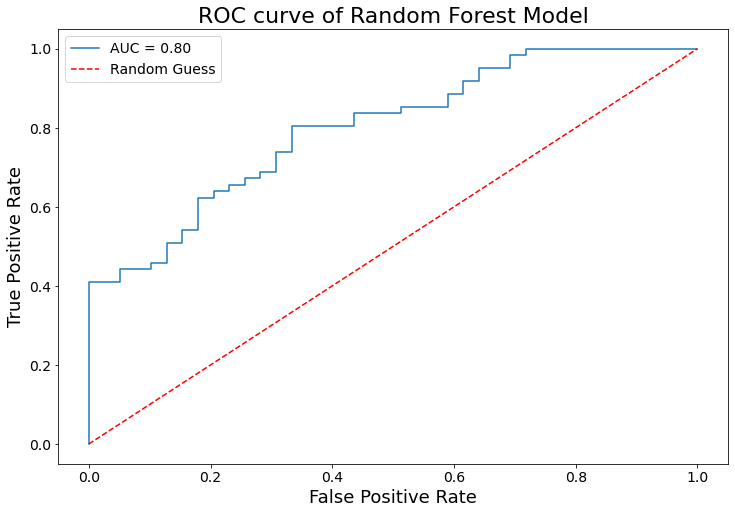

In [66]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[1].to_cupy().get())
auc = metrics.roc_auc_score(y_test, y_pred_proba[1].to_cupy().get())
leg1 = 'AUC = {:0.2f}'.format(auc)
plt.figure(figsize = (12,8))
plt.plot(fpr, tpr, label = leg1)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.plot([0,1],[0,1], linestyle='--', color='Red', label = 'Random Guess')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("ROC curve of Random Forest Model", fontsize = 22)
plt.show();

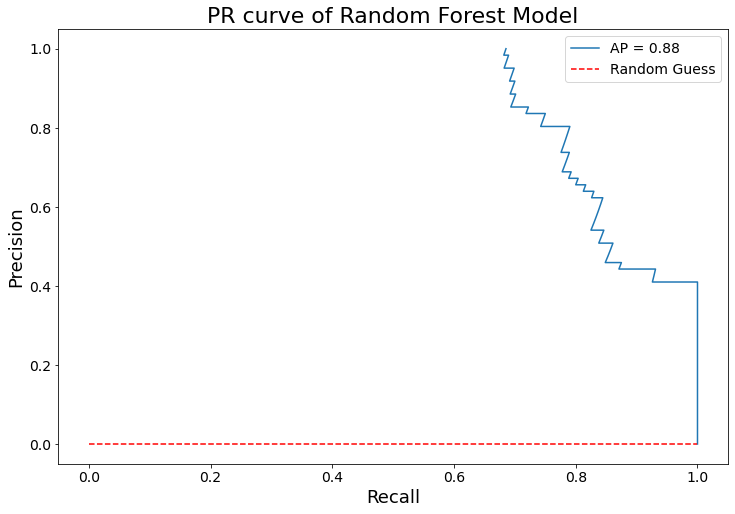

In [75]:
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba[1].to_cupy().get())
pre = metrics.average_precision_score(y_test, y_pred_proba[1].to_cupy().get())
leg1 = 'AP = {:0.2f}'.format(pre)
plt.figure(figsize = (12,8))
plt.plot(precision, recall, label = leg1)
plt.xlabel('Recall', fontsize = 18)
plt.ylabel('Precision', fontsize = 18)
plt.plot([0,1],[0,0], linestyle='--', color='Red', label = 'Random Guess')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("PR curve of Random Forest Model", fontsize = 22)
plt.show();

Even after a lot of hyperparameter tuning, the random forest model is definitely not ideal for dealing with computer vision problems. We believe that the RF model learns too much detail on each photo and thus has very poor generalization performance. 

## Serialize the model for future usage.

In [69]:
import pickle
filename = 'finalized_rf_model.sav'
pickle.dump(cumlll, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))